In [56]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sc
from sklearn.metrics import r2_score
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy

np.set_printoptions(suppress=True)
ROOT.ROOT.EnableImplicitMT()

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.cc","k")

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.cc","k")

Info in <ACLiC>: unmodified script has already been compiled and loaded
Info in <ACLiC>: unmodified script has already been compiled and loaded


In [57]:
date = "JUN29"

chain = ROOT.TChain("events")
chain.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1039_GFcat_Phi3Cat_2018.root".format(date))


1

In [60]:
df_SGN = ROOT.RDataFrame(chain)
df_SGN = df_SGN.Define("scale", "w*lumiIntegrated")\
            .Define("goodMeson_ditrk_mass_GEN", "get2BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 333, 25)[3]")\
            .Define("goodMeson_ditrk_eta_GEN", "get2BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 333, 25)[1]")\
            .Define("goodMeson_ditrk_phi_GEN", "get2BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 333, 25)[2]")\
            .Define("goodMeson_ditrk_pt_GEN", "get2BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 333, 25)[0]")\
            .Define("goodMeson_leadtrk_pt_GEN", "getMaximum(getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, 211, 333, 25), getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, -211, 333, 25))")\
            .Define("goodMeson_subleadtrk_pt_GEN", "getMinimum(getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, 211, 333, 25), getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, -211, 333, 25))")\
            .Define("goodPhotons_pt_GEN", "getPt(GenPart_pt, GenPart_pdgId, GenPart_genPartIdxMother, 22, 25)")\
            .Define("goodMeson_DR_GEN", "getDR(GenPart_eta, GenPart_phi, GenPart_pdgId, GenPart_genPartIdxMother, -211, 333, 25, 211, 333, 25)")\
            .Define("goodMeson_mass_GEN", "get3BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 111, 333, 25)[3]")\
            .Define("goodMeson_pt_GEN", "get3BodyPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, -211, 211, 111, 333, 25)[0]")\
            .Define("HCandMass_GEN", "getHiggsPtEtaPhiM(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother, 333, 25, 22, 25)[3]")\
            .Define("HCandMassMissing", "compute_HiggsVars_var(goodMeson_ditrk_pt[0],goodMeson_ditrk_eta[0],goodMeson_ditrk_phi[0],goodMeson_ditrk_mass[0],photon_pt,goodPhotons_eta[index_pair[1]],goodPhotons_phi[index_pair[1]],0)")\
            .Define("HCandMassMissing_GEN", "getHiggsPtEtaPhiMPhi3Ditrack(GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, GenPart_pdgId, GenPart_genPartIdxMother)[3]")\
            .Define("goodMeson_ditrk_pt_sum", "sum2Body(goodMeson_trk1_pt[0], goodMeson_trk1_eta[0], goodMeson_trk1_phi[0], pi1_mass, goodMeson_trk2_pt[0], goodMeson_trk2_eta[0], goodMeson_trk2_phi[0], pi1_mass).Pt()")\
            .Define("goodMeson_ditrk_eta_sum", "sum2Body(goodMeson_trk1_pt[0], goodMeson_trk1_eta[0], goodMeson_trk1_phi[0], pi1_mass, goodMeson_trk2_pt[0], goodMeson_trk2_eta[0], goodMeson_trk2_phi[0], pi1_mass).Eta()")\
            .Define("goodMeson_ditrk_phi_sum", "sum2Body(goodMeson_trk1_pt[0], goodMeson_trk1_eta[0], goodMeson_trk1_phi[0], pi1_mass, goodMeson_trk2_pt[0], goodMeson_trk2_eta[0], goodMeson_trk2_phi[0], pi1_mass).Phi()")\
            .Define("goodMeson_ditrk_mass_sum", "sum2Body(goodMeson_trk1_pt[0], goodMeson_trk1_eta[0], goodMeson_trk1_phi[0], pi1_mass, goodMeson_trk2_pt[0], goodMeson_trk2_eta[0], goodMeson_trk2_phi[0], pi1_mass).M()")\
            .Define("Diff_pt_original", "(goodMeson_ditrk_pt[0]-goodMeson_ditrk_pt_GEN)/goodMeson_ditrk_pt_GEN")\
            .Define("Diff_pt_sum", "(goodMeson_ditrk_pt_sum-goodMeson_ditrk_pt_GEN)/goodMeson_ditrk_pt_GEN")\
            .Define("Diff_eta_original", "(goodMeson_ditrk_eta[0]-goodMeson_ditrk_eta_GEN)/goodMeson_ditrk_eta_GEN")\
            .Define("Diff_eta_sum",     "(goodMeson_ditrk_eta_sum-goodMeson_ditrk_eta_GEN)/goodMeson_ditrk_eta_GEN")\
            .Define("Diff_phi_original", "(goodMeson_ditrk_phi[0]-goodMeson_ditrk_phi_GEN)/goodMeson_ditrk_phi_GEN")\
            .Define("Diff_phi_sum",     "(goodMeson_ditrk_phi_sum-goodMeson_ditrk_phi_GEN)/goodMeson_ditrk_phi_GEN")\
            .Define("Diff_mass_original", "(goodMeson_ditrk_mass[0]-goodMeson_ditrk_mass_GEN)/goodMeson_ditrk_mass_GEN")\
            .Define("Diff_mass_sum",     "(goodMeson_ditrk_mass_sum-goodMeson_ditrk_mass_GEN)/goodMeson_ditrk_mass_GEN")

In [59]:
#df_SGN = df_SGN.Filter("abs(goodMeson_ditrk_pt_GEN-goodMeson_ditrk_pt[0])<20")
#df_SGN = df_SGN.Filter("abs(goodMeson_ditrk_pt_GEN < 50")


,Diff_pt_original,Diff_pt_sum
0,0.010839,0.010838
1,-0.003693,-0.003694
2,0.012729,0.012728
3,-0.005420,-0.005419
4,0.000369,0.000371
...,...,...
43054,-0.003130,-0.003114
43055,-0.001084,-0.001089
43056,0.015674,0.015675
43057,-0.008018,-0.008004


53.58595
Original:  0.2862137803918121
Sum:  0.2888255858188591


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2


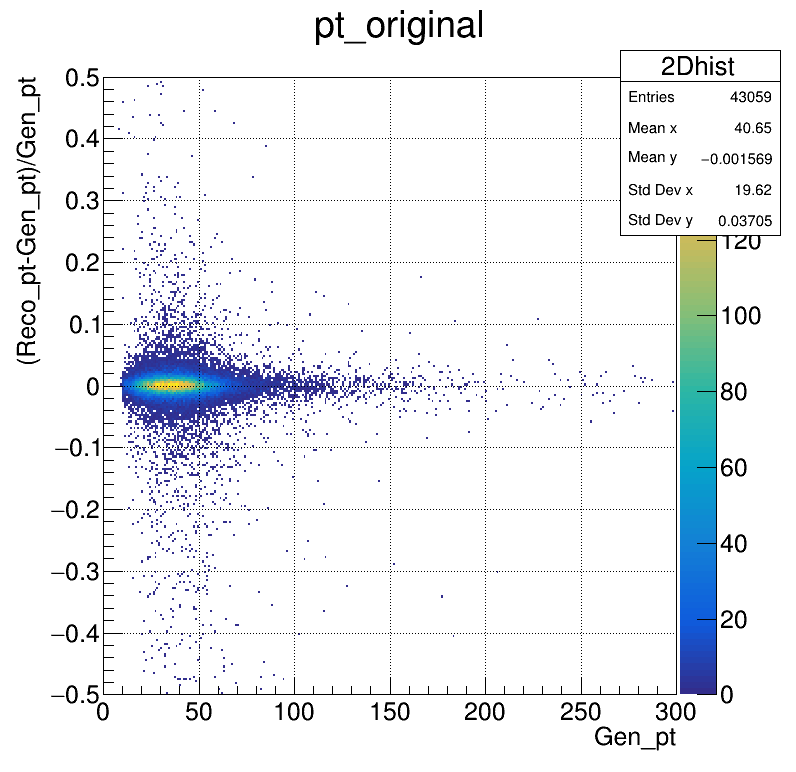

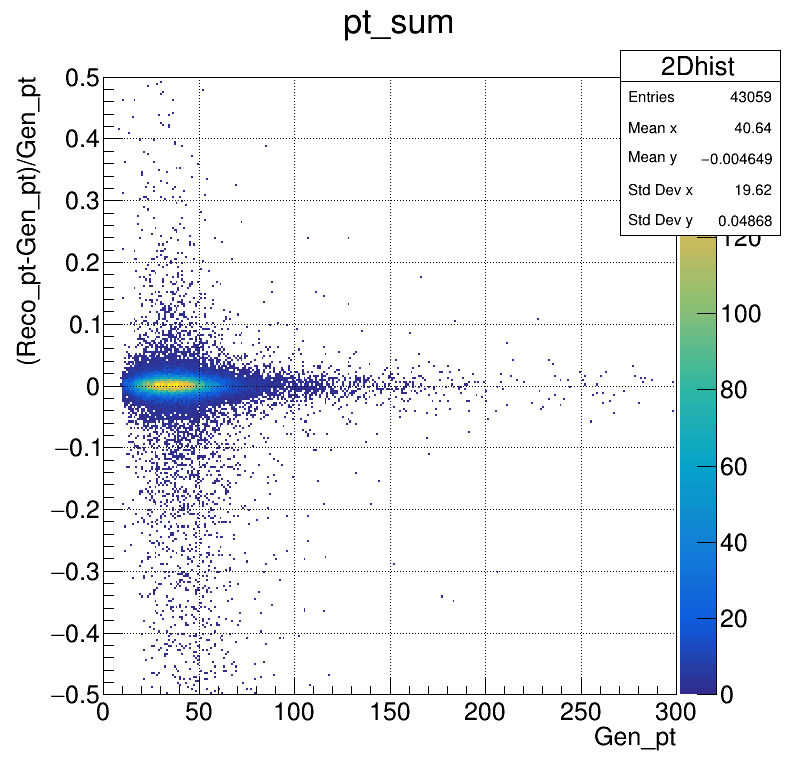

In [61]:
canvas = ROOT.TCanvas("canvas", "canvas", 800, 800)

nbins, xlow, xhigh, ylow, yhigh = 300, 0, 300, -0.5, 0.5

var = "pt"
meth = "original"

h = df_SGN.Histo2D(("2Dhist", var + "_" + meth, nbins, xlow, xhigh, nbins, ylow, yhigh), "goodMeson_ditrk_{}_GEN".format(var), "Diff_{}_{}".format(var, meth))

h.GetXaxis().SetTitle("Gen_{0}".format(var))
h.GetYaxis().SetTitle("(Reco_{0}-Gen_{0})/Gen_{0}".format(var))
h.GetZaxis().SetTitle("Events")
canvas.SetRightMargin(0.15)
canvas.SetLeftMargin(0.13)

h.SetContour(100)
h.Draw("colz")
canvas.SetGrid()

canvas.Draw()

canvas2 = ROOT.TCanvas("canvas2", "canvas2", 800, 800)

meth = "sum"

h2 = df_SGN.Histo2D(("2Dhist", var + "_" + meth, nbins, xlow, xhigh, nbins, ylow, yhigh), "goodMeson_ditrk_{}_GEN".format(var), "Diff_{}_{}".format(var, meth))

h2.GetXaxis().SetTitle("Gen_{0}".format(var))
h2.GetYaxis().SetTitle("(Reco_{0}-Gen_{0})/Gen_{0}".format(var))
h2.GetZaxis().SetTitle("Events")
canvas2.SetRightMargin(0.15)
canvas2.SetLeftMargin(0.13)

h2.SetContour(100)
h2.Draw("colz")
canvas2.SetGrid()

canvas2.Draw()

cols = ["Diff_{}_original".format(var), "Diff_{}_sum".format(var)]
x = df_SGN.AsNumpy(columns=cols)
pddf = pd.DataFrame(x)

display(pddf)

orig = pddf["Diff_{}_original".format(var)].to_numpy()
print(np.max(orig))
summed = pddf["Diff_{}_sum".format(var)].to_numpy()
print("Original: ", np.sqrt(np.sum(orig**2)/len(orig)))
print("Sum: ", np.sqrt(np.sum(summed**2)/len(summed)))

,goodMeson_ditrk_pt_GEN,goodMeson_ditrk_pt
0,86.499954,[87.4375]
1,46.592583,[46.4205207824707]
2,46.621906,[47.215335845947266]
3,37.484329,[37.28117752075195]
4,10.427201,[10.431047439575195]
...,...,...
43054,16.308096,[16.257057189941406]
43055,56.997398,[56.935638427734375]
43056,28.905689,[29.3587703704834]
43057,39.030731,[38.717769622802734]


[86.499954 46.592583 46.621906 ... 28.90569  39.03073  32.966507] [87.4375     46.42052078 47.21533585 ... 29.35877037 38.71776962
 33.13863754] (43059,) (43059,)


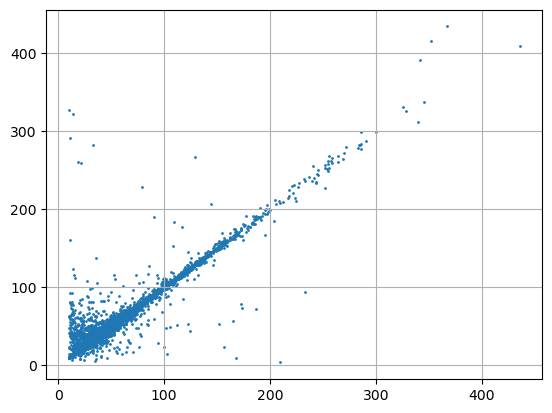

[1.07960106 0.97880436]
[0.05751134 0.0012689 ]
r2:  0.9325211666912929
reco:  0.28621377802347747
lin :  0.2823699534003427


In [63]:
def getRSME(reco, gen):
    err = ((reco-gen)/gen)
    #return np.sum(np.abs(err))/len(err)
    return np.sqrt(np.sum(err**2)/len(err))


var = "pt"

cols = ["goodMeson_ditrk_{}_GEN".format(var), "goodMeson_ditrk_{}".format(var)]
x = df_SGN.AsNumpy(columns=cols)
pddf = pd.DataFrame(x)
display(pddf)

gen = pddf["goodMeson_ditrk_{}_GEN".format(var)].to_numpy()
reco = np.asarray([x[0] for x in pddf["goodMeson_ditrk_{}".format(var)]])
print(gen, reco, gen.shape, reco.shape)

plt.scatter(reco, gen, s=1)
plt.grid()
plt.show()

def funclin(t, a, b):
    return a + b*t

p,q = sc.curve_fit(funclin, reco, gen)
print(p)
print(np.sqrt(np.diag(q)))
print("r2: ", r2_score(gen, funclin(reco, *p)))

print("reco: ", getRSME(reco, gen))
print("lin : ", getRSME(funclin(reco, *p), gen))

In [64]:
cols = ["goodMeson_ditrk_pt_GEN", "goodMeson_ditrk_pt", "goodMeson_ditrk_eta", "goodMeson_ditrk_phi", "goodMeson_ditrk_mass", "goodPhotons_pt", "goodPhotons_eta", "goodPhotons_phi"]
x = df_SGN.AsNumpy(columns=cols)
pddf = pd.DataFrame(x)
for e in cols[1:]:
    pddf[e] = pddf[e].apply(lambda vec: vec[0])
    
display(pddf)

y = pddf.to_numpy()[:,0]
X = pddf.to_numpy()[:,1:]

print(len(X), len(y))
print(type(X), type(y))
print(X.shape, y.shape)
print(X[0], y[0])

,goodMeson_ditrk_pt_GEN,goodMeson_ditrk_pt,goodMeson_ditrk_eta,goodMeson_ditrk_phi,goodMeson_ditrk_mass,goodPhotons_pt,goodPhotons_eta,goodPhotons_phi
0,86.499954,87.437500,1.957913,-0.830365,0.615680,155.392029,0.993286,-0.639526
1,46.592583,46.420521,-0.194102,2.058732,0.537395,68.151367,0.386047,-0.922974
2,46.621906,47.215336,-0.008704,2.875837,0.637113,44.954712,-0.236542,0.068420
3,37.484329,37.281178,0.013492,0.469256,0.532439,58.729229,-0.732788,-2.393066
4,10.427201,10.431047,-0.000297,1.551104,0.412459,53.331707,0.884521,-1.708252
...,...,...,...,...,...,...,...,...
43054,16.308096,16.257057,0.627062,2.436825,0.638289,97.257080,-0.137054,-0.223969
43055,56.997398,56.935638,0.150037,-1.522545,0.737727,52.153172,0.286438,1.530029
43056,28.905689,29.358770,1.021354,-0.199377,0.514360,63.876568,0.837524,2.655762
43057,39.030731,38.717770,1.154346,-0.861660,0.591355,59.576283,0.208008,2.289551


43059 43059
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(43059, 7) (43059,)
[ 87.4375       1.95791256  -0.83036548   0.6156795  155.39202881
   0.99328613  -0.63952637] 86.49995422363281


In [145]:
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True)

# Before we convert data into tensors, we standarize the data (to (x-mu)/sigma)
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
# y are to be reshaped to (-1, 1), i.e., transposed
print(X_train, type(X_train), X_train.shape)
X_train = torch.tensor(X_train, dtype=torch.float32)
#print(y_train, type(y_train), y_train.shape)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
#print(y_train, type(y_train), y_train.shape)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

[[-0.30815443  2.13671057 -0.8741536  ... -0.86283863  0.31593939
   0.69984412]
 [ 0.41234609  1.34230259  0.06739018 ... -0.13110229  0.85939269
  -1.73010652]
 [-0.93744692  0.59374184  1.02352654 ... -0.21350814  0.05966582
  -0.67534172]
 ...
 [-0.11299776  1.60856795  0.22149623 ... -0.70823553  0.21999851
  -1.32165172]
 [-0.32262872 -1.49303991  1.36533381 ... -0.50161883 -0.92481549
  -0.40173988]
 [ 0.15902468 -0.86928993  0.23768534 ...  0.15673113 -0.43565037
  -1.55567937]] <class 'numpy.ndarray'> (25835, 7)


In [151]:
# Define the model. It has N layers
# Start with 7 features
# End with 1, we only want to predict one value
# Usually we go from big and we decrease the size of the layers
model = nn.Sequential(
    nn.Linear(7, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
)

In [171]:
# Define loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#print(loss_fn)
#print(optimizer)

In [153]:
history = []

In [172]:
n_epochs = 50   # number of epochs to run
batch_size = 10000  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None


for epoch in tqdm.tqdm(range(n_epochs)):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=1.0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
        print(epoch, best_mse)

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))

  2%|▏         | 1/50 [00:01<00:56,  1.16s/it]

0 25.677715301513672


  4%|▍         | 2/50 [00:02<00:51,  1.07s/it]

1 25.669357299804688


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]

MSE: 25.67
RMSE: 5.07


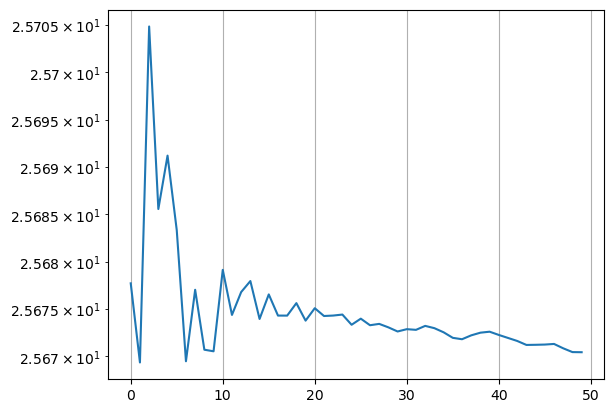

In [175]:
plt.plot(history[170:])
plt.grid()
plt.yscale('log')
plt.show()

In [176]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print("Prediction: {:.4f}, Reco: {:.4f}, Gen: {:.4f}".format(np.round(y_pred[0].numpy()[0], 4), round(X_test_raw[i,0], 4), np.round(y_test[i].numpy()[0], 4)))

with torch.no_grad():
    X_sample = torch.tensor(scaler.transform(X_test_raw), dtype=torch.float32)
    y_pred = model(X_sample)
    gen = y_test.numpy().flatten()
    reco = X_test_raw[:,0]
    pred = y_pred.numpy().flatten()
    print(getRSME(reco, gen))
    print(getRSME(pred, gen))

Prediction: 45.4058, Reco: 45.4453, Gen: 45.2969
Prediction: 33.6592, Reco: 34.1055, Gen: 34.6239
Prediction: 43.8104, Reco: 43.7188, Gen: 42.6562
Prediction: 36.9493, Reco: 36.6562, Gen: 36.5935
Prediction: 16.1357, Reco: 12.9335, Gen: 12.5152
0.10698676846212107
0.11338343977411554
